Import Libraries

In [371]:
import requests
import yfinance as yf
import pandas as pd
import pandas_datareader as web
from datetime import datetime, timedelta
import math
import matplotlib.pyplot as plt
from random import gauss
import matplotlib.pyplot as plt
import numpy as np
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Enter Ticker Name (Stock, ETF, FX, Crypto)

In [372]:
ticker = 'MSFT'

Instructions for TwelveData Finance Data 

In [373]:
# Designate Period (YYYY-MM-DD)
start_date = '2020-01-01'
end_date = '2024-01-01'

# Designate Interval to Track
interval = '1month'

# API Call Data
api_key = '1cd34981158f47d2933af4113984b78a'
api_url = f'https://api.twelvedata.com/time_series?symbol={ticker}&start_date={start_date}&end_date={end_date}&interval={interval}&outputsize=12&apikey={api_key}'
data = requests.get(api_url).json()

# Convert Data to Pandas Data Frame
pd_data = pd.DataFrame(data['values'])

Instructions for Yahoo Finance Data 


In [374]:
yf_ticker = yf.Ticker(ticker)
yf_hist = yf_ticker.history(period='2y')
pd_yf_hist = pd.DataFrame(yf_hist)
yf_cvals = pd_yf_hist['Close']

Use TwelveData Finance Data to find Interval Return Values

In [375]:
# Append 'Close Values' at Every Interval for Given Period. Prints 12 most recent values.
# Note: index 0 is the most recent data, index 1 would be older data (less recent)
close_vals = pd_data['close']

# create function to calculate the percentage change on returns between each interval within period
def return_vals_func(values):
    array = []

    for i in range(len(values)-1):
        recent_val = float(values[i])
        later_val = float(values[i+1])
        chng = round((((recent_val - later_val)/later_val)*100),2)
        array.append(chng)
    
    return array[::-1]

# variable to store the list of pct changes per period created from the above function.
return_vals = return_vals_func(close_vals)

# calculate average return (overall). Print ticker and average return for period.
avg_return = round((sum(return_vals) / len(return_vals)),2)
print(f'Ticker: {ticker}')
print(f'Average Return over period ({start_date} to {end_date}) for Time Interval {interval} : {avg_return}%')

# create a second function to track deviation per period from average return
def deviations_calc(values, baseline):
    array1 = []

    for i in range(len(values) - 1):
        deviation = round((baseline - values[i]),2)
        array1.append(deviation)

    return array1

# variable to store the differences in pct per period based on average return, created from above function.
deviation_vals = deviations_calc(return_vals, avg_return)

# create a third function to manually square a list of values. Ensures that negative deviations don't...
# ...cancel out positive values.
def sqrd(values):
    array2 = []

    for val in values:
        array2.append(val**2)

    return array2

# variable to store the squared list of deviations
squared_deviation_vals = sqrd(deviation_vals)

# create variables to calculate variance and standard deviation.
var = round((sum(squared_deviation_vals) / (len(squared_deviation_vals)-1)),2)
sdev = math.sqrt(var)
print(f'Market Volatility (Standard Deviation): {sdev}')

Ticker: MSFT
Average Return over period (2020-01-01 to 2024-01-01) for Time Interval 1month : 4.03%
Market Volatility (Standard Deviation): 6.356886030125127


Check PACF Plot to Identify GARCH Parameters

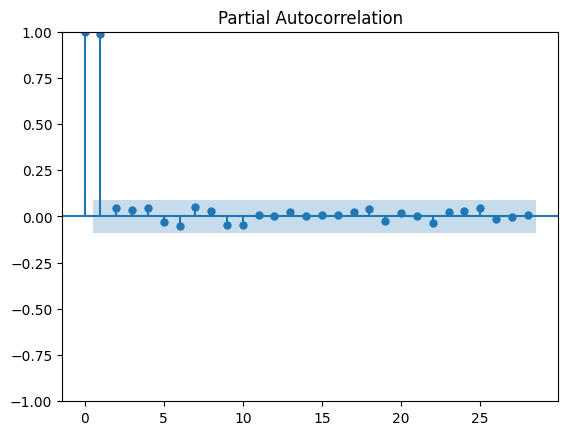

In [376]:
plot_pacf(np_yf_cvals**2)
plt.show()

Instructions for GARCH(1,1) Model

In [377]:
# Establish variables
n = len(np_yf_cvals)
omega = 0.5
alpha_1 = 0.1
#alpha_2 = 0.2
beta_1 = 0.3
#beta_2 = 0.4

# Compress results for n to scale large data
test_size = int(n*0.1)

# Create loop to identify volatilities (vols). Append vols to list.
vols_list = [1]
for i in range(n-1):
    vol = np.sqrt(omega + alpha_1*np_yf_cvals[-1]**2 + beta_1*vols_list[-1]**2)
    vols_list.append(vol)

Plot GARCH(1,1) Model

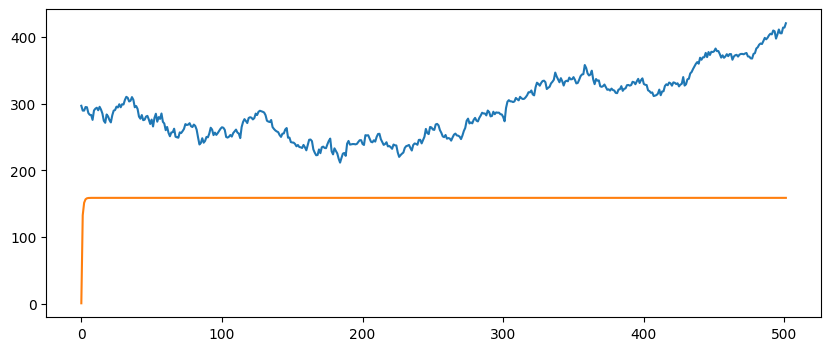

In [378]:
# Plot actual x and y values of historical data
x_values = len(np_yf_cvals)
y_values = vols_list

plt.figure(figsize=(10,4))
plt.plot(np_yf_cvals)
plt.plot(vols_list)

Train / Fit (1,1) Model

In [379]:
train, test = np_yf_cvals[:-test_size], np_yf_cvals[-test_size:]
model = arch_model(train, p=1, q=1)
model_fit = model.fit()
model_fit.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 12752.029098564994
Iteration:      2,   Func. Count:     13,   Neg. LLF: 2125.2798413949977
Iteration:      3,   Func. Count:     18,   Neg. LLF: 2973.345003254986
Iteration:      4,   Func. Count:     25,   Neg. LLF: 2123.0727188665974
Iteration:      5,   Func. Count:     30,   Neg. LLF: 2122.8847185873606
Iteration:      6,   Func. Count:     35,   Neg. LLF: 2122.867252033973
Iteration:      7,   Func. Count:     40,   Neg. LLF: 2122.8638048361518
Iteration:      8,   Func. Count:     45,   Neg. LLF: 2122.8637842480425
Iteration:      9,   Func. Count:     50,   Neg. LLF: 2122.863684261906
Iteration:     10,   Func. Count:     55,   Neg. LLF: 2122.8634676167153
Iteration:     11,   Func. Count:     60,   Neg. LLF: 2122.863461241908
Iteration:     12,   Func. Count:     65,   Neg. LLF: 2122.8634604619965
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2122.8634604619965
            Iterati

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2122.86
Distribution:                  Normal   AIC:                           4253.73
Method:            Maximum Likelihood   BIC:                           4270.18
                                        No. Observations:                  452
Date:                Sun, Feb 11 2024   Df Residuals:                      451
Time:                        12:05:39   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu           257.3547      1.695    151.848      0.000 [2.540e+02,2.607e+02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega         22.8409      6.084      3.754  1.739e-04 [ 10.916, 34.766]
alpha[1]       0.9966  9.861e-02     10.107  5.124e-24 [  0.803,  1.190]
beta[1]    3.3501e-03  9.271e-02  3.614e-02      0.971 [ -0.178,  0.185]
========================================================================

Covariance estimator: robust
"""

Model Volatility Predictions

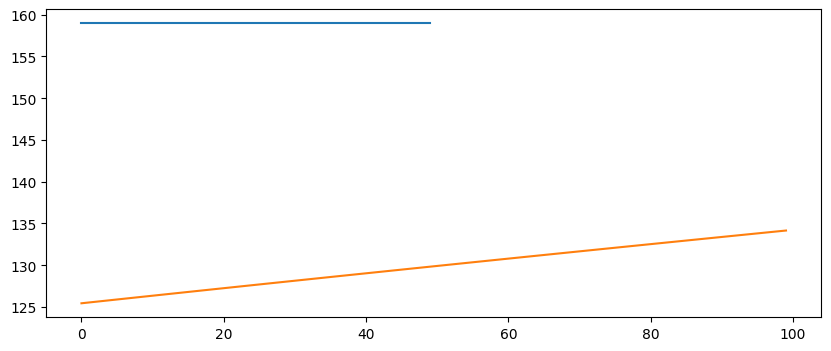

In [380]:
predictions = model_fit.forecast(horizon=test_size*2)
plt.figure(figsize=(10,4))
true, = plt.plot(vols_list[-test_size:])
preds, = plt.plot(np.sqrt(predictions.variance.values[-1,:]))

Model Rolling Volatility Predictions

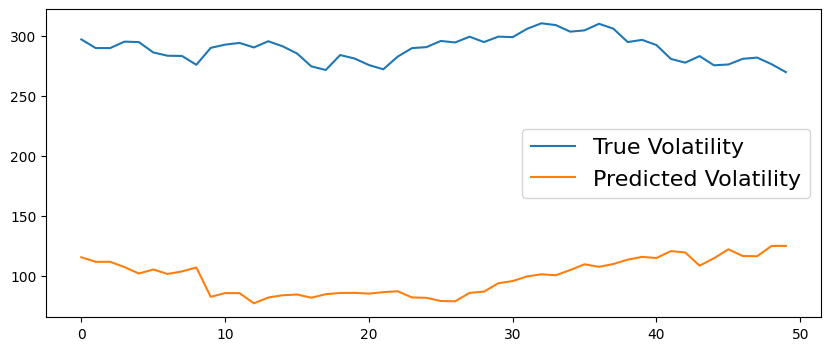

In [381]:
predictions = model_fit.forecast(horizon=test_size*2)

rolling_predictions = []
for i in range(test_size):
    train = np_yf_cvals[:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]) - 10)

#plt.figure(figsize=(10,4))
#true, = plt.plot(np_yf_cvals[:-test_size-i])
#preds, = plt.plot(rolling_predictions)

plt.figure(figsize=(10,4))
true, = plt.plot((np_yf_cvals[:-test_size-i])[:len(rolling_predictions)])
preds, = plt.plot(rolling_predictions)
plt.legend(['True Volatility', 'Predicted Volatility'], fontsize=16)

